In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json

import os

In [2]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
os.makedirs(os.path.dirname('PhaseField2DPINN/'), exist_ok=True)

In [4]:
delta = 0.65
W0 = 1
tau0 = 1
D = 1
landa = 1 

dx = 20
dy = 20
t = 60

# nuclei radius
r = 8

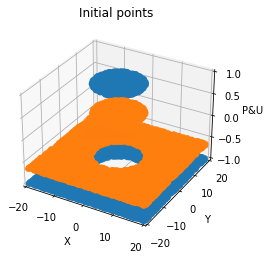

In [5]:
initial_points = 10000

ic_x = np.random.uniform(low=-dx, high=dx, size=[initial_points, 1])
ic_y = np.random.uniform(low=-dy, high=dy, size=[initial_points, 1])
ic_xx = ic_x * ic_x
ic_yy = ic_y * ic_y

ic_t = np.zeros(shape=[initial_points, 1]) #t=0
ic_p = np.where(np.sqrt((ic_x) ** 2 + (ic_y) ** 2) < r, 1, -1)
ic_u = np.where(np.sqrt((ic_x) ** 2 + (ic_y) ** 2) < r, 1-delta, -delta)

input1 = np.hstack([ic_x, ic_y, ic_xx, ic_yy, ic_t])
label1 = np.hstack([ic_u, ic_p])


# Saving initial points diagram
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(ic_x, ic_y, ic_p, 'bo' )
ax.scatter(ic_x, ic_y, ic_u , 'ro')

ax.set_title('Initial points')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('P&U')

ax.set_xlim(-dx, dx)
ax.set_ylim(-dy, dy)
ax.set_zlim(-1, 1)

fig.savefig('PhaseField2DPINN/Initial.png', transparent=True, dpi=300)

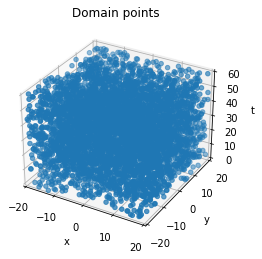

In [6]:
domain_points = 5000
d_x = np.random.uniform(low=-dx, high=dx, size=[domain_points, 1])
d_y = np.random.uniform(low=-dy, high=dy, size=[domain_points, 1])
d_xx = d_x * d_x
d_yy = d_y * d_y
d_t = np.random.uniform(low=0, high=t, size=[domain_points, 1])

input2 = np.hstack([d_x, d_y, d_xx, d_yy, d_t])


# Saving domain points diagram
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(d_x, d_y, d_t, 'bo')

ax.set_xlim(-dx, dx)
ax.set_ylim(-dy, dy)
ax.set_zlim(0, t)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.set_title('Domain points')

fig.savefig('PhaseField2DPINN/Domain.png', transparent=True, dpi=300)

In [ ]:
input_u = tf.convert_to_tensor(np.vstack([input1]), dtype=tf.float32) # initial
label_u = tf.convert_to_tensor(np.vstack([label1]), dtype=tf.float32) # initial

input_f = tf.convert_to_tensor(np.vstack([input1, input2]), dtype=tf.float32) # intiial + domain

In [8]:
# Generating random test data for evaluation

x_test = np.random.uniform(low=-dx, high=dx, size=[2000, 1])
y_test = np.random.uniform(low=-dy, high=dy, size=[2000, 1])

xx_test = x_test * x_test
yy_test = y_test * y_test

t_test = np.random.uniform(low=0, high=t, size=[2000, 1])

input_test = tf.convert_to_tensor(np.hstack([x_test, y_test, xx_test, yy_test, t_test]), dtype=tf.float32)

In [9]:
# f : Physics 
def f(input):
    x = input[:, 0:1]
    y = input[:, 1:2]
    xx = input[:, 2:3]
    yy = input[:, 3:4]
    t = input[:, 4:5]

    with tf.GradientTape(persistent=True) as gg:
        # gg for second derivatives

        gg.watch([x, y, t])

        with tf.GradientTape(persistent=True) as g:
            #g for first derivatives

            g.watch([x, y, t])

            z = tf.concat([x, y, xx, yy, t], 1)

            u = model(z)[:, 0:1]
            p = model(z)[:, 1:2]

        dp_dx = g.gradient(p, x) 
        dp_dy = g.gradient(p, y) 
        dp_dt = g.gradient(p, t) 

        du_dx = g.gradient(u, x)
        du_dy = g.gradient(u, y)
        du_dt = g.gradient(u, t) 

        del g
    

    dp_dxx = gg.gradient(dp_dx, x) 
    dp_dxy = gg.gradient(dp_dx, y) 
    dp_dyy = gg.gradient(dp_dy, y) 
    du_dxx = gg.gradient(dp_dx, x) 
    du_dyy = gg.gradient(dp_dy, y)

    del gg
        
    
    f87 = du_dt - D * (du_dxx + du_dyy) - 0.5 * dp_dt
    f88 = dp_dt - (p - landa * u * (1 - p**2)) * (1 - p**2) - dp_dxx - dp_dyy 
    
    return f87, f88

In [10]:
#Network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(5)) #x, y, xx, yy, t
model.add(tf.keras.layers.Dense(units=60, activation='softmax'))
model.add(tf.keras.layers.Dense(units=60, activation='tanh'))
model.add(tf.keras.layers.Dense(units=60, activation='softmax'))
model.add(tf.keras.layers.Dense(units=60, activation='tanh'))
model.add(tf.keras.layers.Dense(units=60, activation='softmax'))
model.add(tf.keras.layers.Dense(units=60, activation='tanh'))
model.add(tf.keras.layers.Dense(units=2)) #u, p

In [11]:
# Custom Loss functions

MSE = tf.keras.losses.MeanSquaredError()

def loss_u(model, x, y):
    return MSE(y_true=y, y_pred=model(x))

def loss_f(model, x):
    return MSE(y_true=0, y_pred=f(x))

def loss(model, x, y):
    return  100 * loss_u(model, x, y) +  loss_f(model, x)

In [ ]:
# Generating gradients w.r.t network variables

def grad_u(model, input, label):
    with tf.GradientTape() as g:
        loss_value = loss_u(model, input, label)
    return loss_value, g.gradient(loss_value, model.trainable_variables)

def grad_f(model, input):
    with tf.GradientTape() as g:
        loss_value = loss_f(model, input)
    return loss_value, g.gradient(loss_value, model.trainable_variables)

def grad(model, input, label):
    with tf.GradientTape() as g:
        loss_value = loss(model, input, label)
    return loss_value, g.gradient(loss_value, model.trainable_variables)

In [12]:
optimizer = tf.keras.optimizers.Adam() # Learning rate = 1e-3

model.compile(optimizer=optimizer)

In [13]:
train_history = {'loss_f_train': [], 'loss_f_test': [], 'loss_u_train': []}

In [14]:
epochs = 6001

for epoch in range(epochs):
    
    loss_value, grads = grad(model, input_u, label_u)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    loss_value_f_train, _ = grad_f(model, input_f)
    loss_value_u_train, _ = grad_u(model, input_u, label_u)
    loss_value_f_test, _ = grad_f(model, input_test)

    train_history['loss_f_test'].append(loss_value_f_test.numpy())
    train_history['loss_f_train'].append(loss_value_f_train.numpy())
    train_history['loss_u_train'].append(loss_value_u_train.numpy())

    if epoch % 100 == 0:
        print("epoch: {}, loss_f_train: {:.6f}, loss_f_test: {:.6f}, loss_u_train: {:.7f}".format(epoch, loss_value_f_train, loss_value_f_test, loss_value_u_train))

epoch: 0, loss_f_train: 0.000069, loss_f_test: 0.000069, loss_u_train: 0.7085754
epoch: 100, loss_f_train: 0.024132, loss_f_test: 0.024062, loss_u_train: 0.2500052
epoch: 200, loss_f_train: 0.029565, loss_f_test: 0.015383, loss_u_train: 0.0046975
epoch: 300, loss_f_train: 0.024166, loss_f_test: 0.016458, loss_u_train: 0.0025072
epoch: 400, loss_f_train: 0.025818, loss_f_test: 0.034408, loss_u_train: 0.0018208
epoch: 500, loss_f_train: 0.024067, loss_f_test: 0.027726, loss_u_train: 0.0013548
epoch: 600, loss_f_train: 0.019290, loss_f_test: 0.019496, loss_u_train: 0.0010204
epoch: 700, loss_f_train: 0.014941, loss_f_test: 0.019767, loss_u_train: 0.0007841
epoch: 800, loss_f_train: 0.011439, loss_f_test: 0.036295, loss_u_train: 0.0006627
epoch: 900, loss_f_train: 0.015991, loss_f_test: 0.008390, loss_u_train: 0.0004844
epoch: 1000, loss_f_train: 0.017104, loss_f_test: 0.042567, loss_u_train: 0.0004003
epoch: 1100, loss_f_train: 0.013750, loss_f_test: 0.035496, loss_u_train: 0.0003326
epoc

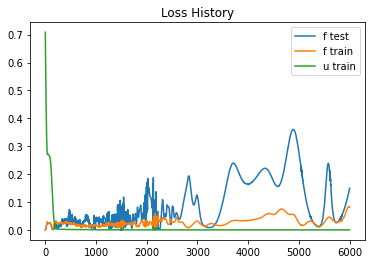

In [15]:
# Plotting loss history

plt.plot(train_history['loss_f_test'], label='f test')
plt.plot(train_history['loss_f_train'], label='f train')
plt.plot(train_history['loss_u_train'], label='u train')
plt.title('Loss History')
plt.legend()

plt.savefig('PhaseField2DPINN/losses.png', dpi=300)

In [16]:
# Saving model

model.save('PhaseField2DPINN/model-karma88.h5')

In [17]:
# Saving Loss data (f_train, f_test, u_train)

with open('PhaseField2DPINN/Losses.txt', 'w') as file:
    file.write(str(train_history))

In [18]:
# Generating .plt files for tecplot 

mesh = 350
x = np.linspace(start=-2*dx, stop=2*dx, num=mesh).reshape([mesh, 1])
y = np.linspace(start=-2*dy, stop=2*dy, num=mesh).reshape([mesh, 1])

x_test, y_test = np.meshgrid(x, y)

x_test = x_test.flatten().reshape([mesh**2, 1])
y_test = y_test.flatten().reshape([mesh**2, 1])

xx_test = x_test * x_test
yy_test = y_test * y_test

times = [0, 10, 20, 50, 60, 100, 200]

for time in times:
    t_test = np.ones(shape=[mesh**2, 1]) * time
    
    input_test = tf.convert_to_tensor(np.hstack([x_test, y_test, xx_test, yy_test, t_test]), dtype=tf.float32)
    
    output_test = model(input_test)
    
    u = output_test[:, 0:1]
    p = output_test[:, 1:2]
    
    with open('PhaseField2DPINN/t={time}.plt'.format(time=time), 'w+') as file:
        file.write('TITLE = "Phase Field Results - Time = {time}"\n'.format(time=time))
        file.write('VARIABLES = "X", "Y", "Psi", "U"\n')
        file.write('ZONE I = {n}, J = {n}, F=POINT\n'.format(n=mesh))
        for i in range(mesh**2):
            file.write("{x} {y} {p} {u}\n".format(x=x_test[i][0], y=y_test[i][0], p=p[i].numpy()[0], u=u[i].numpy()[0]))